In [1]:
%matplotlib inline

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

from keras.engine import Layer
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.layers import Input, Dense, Dropout, TimeDistributed, Bidirectional, Flatten
from keras.layers.recurrent import LSTM
from keras.layers import Conv1D, Dense, AveragePooling1D, Flatten, Concatenate, MaxPooling1D ,ConvLSTM2D
from keras.layers import Input, Lambda, Reshape, Activation, Add, UpSampling1D
from keras.models import Model
from keras.models import Sequential
from keras.optimizers import Adam, RMSprop
from keras.layers.normalization import BatchNormalization
from keras.layers import GlobalAveragePooling2D, AveragePooling1D
from keras.utils.generic_utils import get_custom_objects
from sklearn.model_selection import train_test_split
from keras.preprocessing import image
from IPython.display import Image
import glob
import keras 
import pandas as pd
import numpy as np
import os.path
from tqdm import tqdm
from itertools import cycle
from keras.utils import to_categorical
from matplotlib import pyplot as plt
from IPython.display import clear_output
from sklearn import preprocessing

Using TensorFlow backend.


In [2]:
tracked_features = np.load('data/ocellatus_tracked_features.npy')
labels = np.load('data/ocellatus_labels.npy')

In [3]:
# move to utils
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.accs = []
        self.val_accs = []
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.accs.append(logs.get('acc'))
        self.val_accs.append(logs.get('val_acc'))
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.figure(figsize=(15,15))
        plt.subplot(211)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.subplot(212)
        plt.plot(self.x, self.accs, label="acc")
        plt.plot(self.x, self.val_accs, label="val_acc")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

In [121]:
# move to utils
#  deaing with uneven sample sizes
def evenly_subsample_features(labels, features, idx, counts, seq_len, seq_stps, n_features):
    c = cycle([i for i in np.unique(idx)])
    n_examples = int(np.min(counts)-seq_len)
    if seq_stps == 0:
        X = np.empty((n_examples*len(np.unique(idx)), seq_len, n_features))
        Y = np.empty((n_examples*len(np.unique(idx)), seq_len, labels.shape[1]))
        for j in range(n_examples*len(np.unique(idx))):
            i = next(c)
            try:
                ix = np.random.choice(np.where(idx==i)[0])
                X[j, :, :] = features[ix-int(seq_len/2):
                                      ix+int(seq_len/2)]
                Y[j, :, :] = labels[ix-int(seq_len/2):
                                    ix+int(seq_len/2)]
            except ValueError:
                ix = np.random.choice(np.where(idx==i)[0])
                X[j, :, :] = features[ix-int(seq_len/2):
                                      ix+int(seq_len/2)]
                Y[j, :, :] = labels[ix-int(seq_len/2):
                                    ix+int(seq_len/2)]
    else:
        X = np.empty((n_examples*len(np.unique(idx)),
                      seq_stps,
                      int(seq_len/seq_stps),
                      n_features))
        
        Y = np.empty((n_examples*len(np.unique(idx)), labels.shape[1]))
        for j in range(n_examples*len(np.unique(idx))):
            i = next(c)
            try:
                ix = np.random.choice(np.where(idx==i)[0])
                X[j, :, :] = features[ix-int(seq_len/2):
                                      ix+int(seq_len/2)].reshape((seq_stps,
                                              int(seq_len/seq_stps),
                                              n_features))
                Y[j, :] = labels[ix]
            except ValueError:
                ix = np.random.choice(np.where(idx==i)[0])
                X[j, :, :] = features[ix-int(seq_len/2):
                                      ix+int(seq_len/2)].reshape((seq_stps,
                                              int(seq_len/seq_stps),
                                              n_features))
                Y[j, :] = labels[ix]
    return X, Y

In [10]:
# utils
labels = (labels > 0.5).astype(np.int_)  # make labels onehot
_, idx, counts = np.unique(labels, axis=0, return_inverse=True, return_counts=True)
labels = to_categorical(idx)
print(labels.shape, tracked_features.shape)

(40620, 4) (40620, 32)


In [11]:
# utils
# # be aware of the biases of your data
# these can completely undermine your training
_, idx, counts = np.unique(labels, axis=0, return_inverse=True, return_counts=True)
print(_, counts)

[[0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]] [30837   732  8131   920]


In [134]:
# to utils
def pool_1D(inputs, filters, kernel_size=3):
    conv = Conv1D(filters, (kernel_size), padding='same')(inputs)
    conv = Activation('relu')(conv)
    conv = Dropout(0.2)(conv)
    conv = AveragePooling1D()(conv)
    return conv

def upsample_1D(inputs, residual, filters, kernel_size=3):
    conv = Conv1D(filters, (kernel_size), padding='same')(inputs)
    residual = Conv1D(filters, (1))(residual)
    conv = Add()([conv,residual])
    conv = Activation('relu')(conv)
    conv = UpSampling1D()(conv)
    return conv

def build_hourglass_model(input_shape, conv_filter_size=3, conv_kernel_size=3, n_pooling_upsampling_steps=1, n_stacks=1, n_classes=4):
    input_layer = Input(shape=input_shape, name='input')
    x = pool_1D(input_layer, conv_filter_size)
    res1 = x
    outputs = []
    
    for n in range(n_stacks):
        for idx in range(n_pooling_upsampling_steps):
            x = pool_1D(x, conv_filter_size*(idx+1), kernel_size=conv_kernel_size)
            outputs.append(x)

        for idx in range(n_pooling_upsampling_steps):
            x = upsample_1D(x, outputs[-(idx+1)], conv_filter_size*(n_pooling_upsampling_steps-idx), kernel_size=conv_kernel_size)

    x = upsample_1D(x, res1,  conv_filter_size)
    x = Conv1D(n_classes, (conv_kernel_size), padding='same')(x)
    x = Activation('relu')(x)
    model = Model(input_layer, x)
    return model

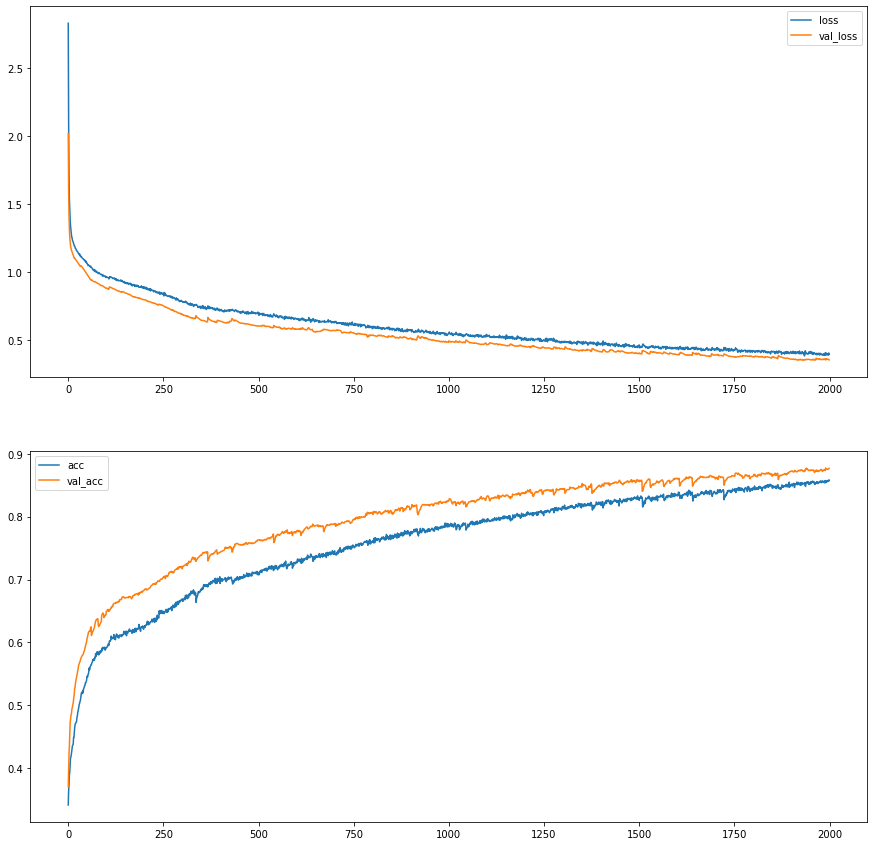

In [135]:
### data
features = preprocessing.scale(tracked_features)

seq_len = 24

X_train, Y_train = evenly_subsample_features(
    labels,
    features,
    idx,
    counts,
    seq_stps=0,  #seq_stps not used in the hourglass model
    seq_len=seq_len,
    n_features=features.shape[1],
)

### model
conv_filter_size=128
conv_kernel_size=1
n_pooling_upsampling_steps=1
n_stacks = 2

hourglass_model = build_hourglass_model(
    input_shape=(
        X_train.shape[1],
        X_train.shape[2]),
    conv_filter_size=conv_filter_size,
    conv_kernel_size=conv_kernel_size,
    n_pooling_upsampling_steps=n_pooling_upsampling_steps,
    n_stacks=n_stacks,
    n_classes=Y_train.shape[2])

loss = 'categorical_crossentropy'
optimizer = Adam(lr=1e-5)
metrics = ['accuracy']

hourglass_model.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=metrics) 

hourglass_model.summary()

### training
batch_size = 64
validation_split = 0.2
n_epochs = 2000

hourglass_model.fit(
    X_train,
    Y_train,
    validation_split=validation_split,
    batch_size=batch_size,
    epochs=n_epochs,
    shuffle=True,
    callbacks=[plot_losses],
    verbose=0
            )

In [16]:
# weights = None
# if weights is None:
#     base_model = InceptionV3(
#         weights='imagenet',
#         include_top=True
#     )
#     feature_model = Model(
#         inputs=base_model.input,
#         outputs=base_model.get_layer('avg_pool').output
#     )
# else:
#     feature_model = load_model(weights)
#     feature_model.layers.pop()
#     feature_model.layers.pop()  # get to pool layer
#     feature_model.outputs = [self.model.layers[-1].output]
#     feature_model.output_layers = [self.model.layers[-1]]
#     feature_model.layers[-1].outbound_nodes = []

# def extract(model, image_path):
#     img = image.load_img(image_path, target_size=(299, 299))
#     x = image.img_to_array(img)
#     x = np.expand_dims(x, axis=0)
#     x = preprocess_input(x)

#     # Get the prediction.
#     features = model.predict(x)

#     features = features[0]

#     return features

In [17]:
# FEATS = np.empty((40620,2048))
# for i, file in enumerate(video_frames):
#     features = extract(feature_model, file)
#     FEATS[i] = features
# np.save('data/ocellatus_inception_features', FEATS)

In [ ]:
# labels = np.loadtxt(annotations, skiprows=1, delimiter=',')
# features = np.load(inception_features)
# labels = (labels > 0.5).astype(np.int_)  # make labels onehot
# _, idx, counts = np.unique(labels, axis=0, return_inverse=True, return_counts=True)
# labels = to_categorical(idx)
# print(labels.shape, features.shape)

In [21]:
# pull out to utils file
def build_basic_lstm_model(input_shape=None, nb_classes=4, lstm_filters=32, dropout=0.5, use_bidirectional=False):    
    inputs = Input(shape=input_shape, name='input')
    if use_bidirectional is True:
        x = Bidirectional(LSTM(lstm_filters, return_sequences=True))(inputs)
    else:
        x = LSTM(lstm_filters, return_sequences=True)(inputs)
    x = Dropout(dropout)(x)
    x = TimeDistributed(Dense(nb_classes, activation='sigmoid'))(x)
    model = Model(inputs, x)
    return model

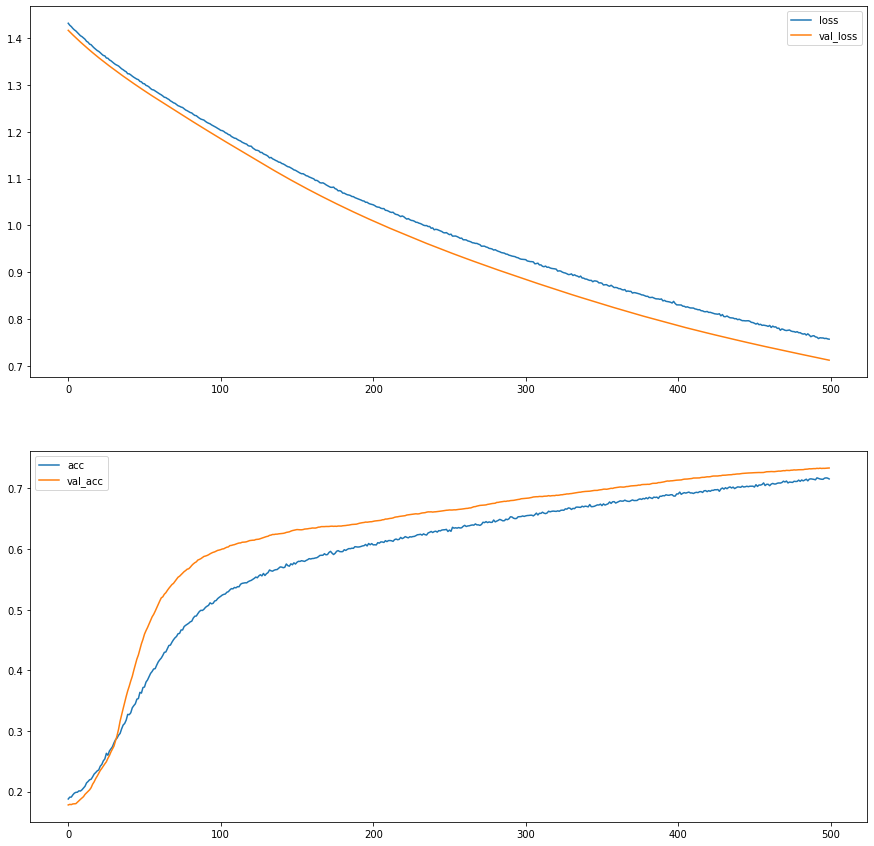

In [23]:
### data
features = preprocessing.scale(tracked_features)

seq_len = 24

X_train, Y_train = evenly_subsample_features(
    labels,
    features,
    idx,
    counts,
    seq_stps=0,  #seq_stps not used in the basic lstm_model
    seq_len=seq_len,
    n_features=features.shape[1],
)

### model
lstm_filters=32
dropout=0.5
use_bidirectional = False

basic_lstm_model = build_basic_lstm_model(
    input_shape=(X_train.shape[1], X_train.shape[2]),
    nb_classes=Y_train.shape[2],
    lstm_filters=lstm_filters,
    dropout=dropout,
    use_bidirectional=use_bidirectional,
)

loss = 'categorical_crossentropy'
optimizer = Adam(lr=1e-5)
metrics = ['accuracy']

basic_lstm_model.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=metrics)

basic_lstm_model.summary()

### training
batch_size = 64
validation_split = 0.2
n_epochs = 500

basic_lstm_model.fit(
    X_train,
    Y_train,
    validation_split=validation_split,
    batch_size=batch_size,
    epochs=n_epochs,
    shuffle=True,
    callbacks=[plot_losses],
    verbose=0
            )

In [24]:
# pull out to utils file
def build_conv_lstm_model(input_shape=None, nb_classes=4, lstm_filters=100, conv_filters=64, conv_kernel_size=1, dropout=0.5, pool_size=2):    
    inputs = Input(shape=input_shape, name='input')
    x = TimeDistributed(Conv1D(filters=conv_filters, kernel_size=conv_kernel_size, activation='relu'))(inputs)
    x = TimeDistributed(Conv1D(filters=conv_filters, kernel_size=conv_kernel_size, activation='relu'))(x)
    x = TimeDistributed(Dropout(dropout))(x)
    x = TimeDistributed(MaxPooling1D(pool_size=pool_size))(x)
    x = TimeDistributed(Flatten())(x)
    x = LSTM(lstm_filters)(x)
    x = Dropout(dropout)(x)
    x = Dense(lstm_filters, activation='relu')(x)
    x = Dense(nb_classes, activation='softmax')(x)
    model = Model(inputs, x)
    return model

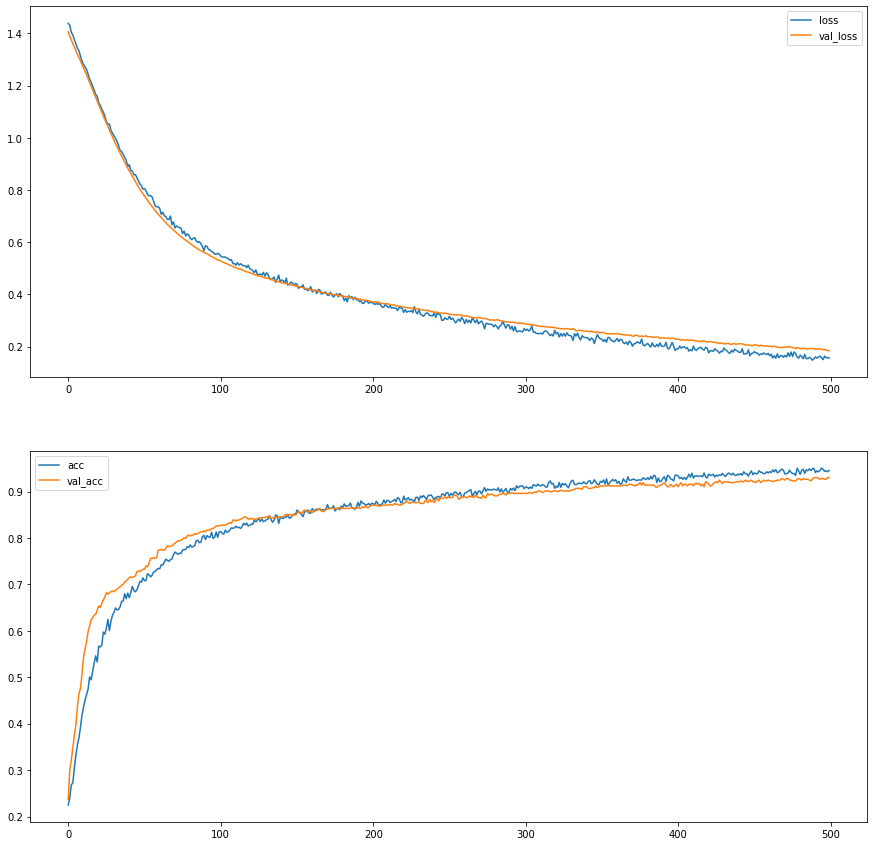

In [25]:
### data
features = preprocessing.scale(tracked_features)

seq_len = 36 
seq_stps = 6

X_train, Y_train = evenly_subsample_features(
    labels,
    features,
    idx,
    counts,
    seq_stps=seq_stps,
    seq_len=seq_len,
    n_features=features.shape[1],
)

print(X_train.shape)

### model
pool_size=2
conv_filters=64
conv_kernel_size=1
lstm_filters=100
dropout=0.5

conv_lstm_model = build_conv_lstm_model(
    input_shape=(
        X_train.shape[1],
        X_train.shape[2],
        X_train.shape[3]),
    pool_size=pool_size,
    conv_filters=conv_filters,
    conv_kernel_size=conv_kernel_size,
    lstm_filters=lstm_filters,
    dropout=dropout,
    nb_classes=Y_train.shape[1],
)

loss = 'categorical_crossentropy'
optimizer = Adam(lr=1e-5)
metrics = ['accuracy']

conv_lstm_model.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=metrics)

conv_lstm_model.summary()

### training
batch_size = 64
validation_split = 0.2
n_epochs = 500

conv_lstm_model.fit(
    X_train, Y_train,
    validation_split=validation_split,
    batch_size=batch_size,
    epochs=n_epochs,
    shuffle=True,
    callbacks=[plot_losses],
    verbose=0
            )

In [50]:
def build_conv_lstm_2d_model(input_shape=None, nb_classes=4, conv_filters=8, conv_kernel_size=(1,1), lstm_filters=20, dropout=0.5):
    inputs = Input(shape=input_shape, name='input')
    x = ConvLSTM2D(filters=conv_filters, kernel_size=conv_kernel_size, activation='relu', recurrent_dropout=dropout)(inputs)
    x = Dropout(dropout)(x)
    x = Flatten()(x)
    x = Dense(lstm_filters, activation='relu')(x)
    x = Dense(nb_classes, activation='softmax')(x)
    model = Model(inputs, x)
    return model

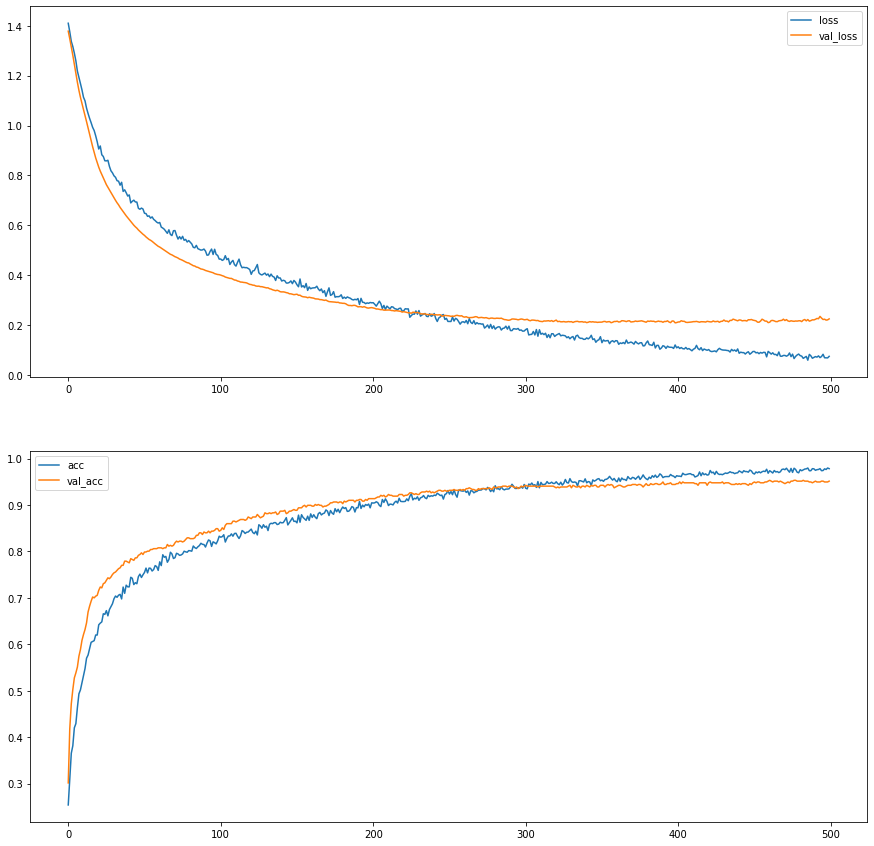

In [31]:
### data
features = preprocessing.scale(tracked_features)

seq_len = 36
seq_stps = 6

X_train, Y_train = evenly_subsample_features(
    labels,
    features,
    idx,
    counts,
    seq_stps=seq_stps,
    seq_len=seq_len,
    n_features=features.shape[1],
)
X_train = X_train.reshape(
    (X_train.shape[0], X_train.shape[1], 1, X_train.shape[2], X_train.shape[3])
)

### model
conv_filters=8
conv_kernel_size=(1,5)
lstm_filters=20
dropout=0.5

conv_lstm_2d_model = build_conv_lstm_2d_model(
    input_shape=(
        X_train.shape[1],
        1,
        X_train.shape[3],
        X_train.shape[4]),
    conv_filters=conv_filters,
    conv_kernel_size=conv_kernel_size,
    lstm_filters=lstm_filters,
    dropout=dropout,
    nb_classes=Y_train.shape[1],
)

loss = 'categorical_crossentropy'
optimizer = Adam(lr=1e-5)
metrics = ['accuracy']

conv_lstm_2d_model.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=metrics)

conv_lstm_2d_model.summary()

### training
batch_size = 64
validation_split = 0.2
n_epochs = 500

conv_lstm_2d_model.fit(
    X_train, Y_train,
    validation_split=validation_split,
    batch_size=batch_size,
    epochs=n_epochs,
    shuffle=True,
    callbacks=[plot_losses],
    verbose=0
            )

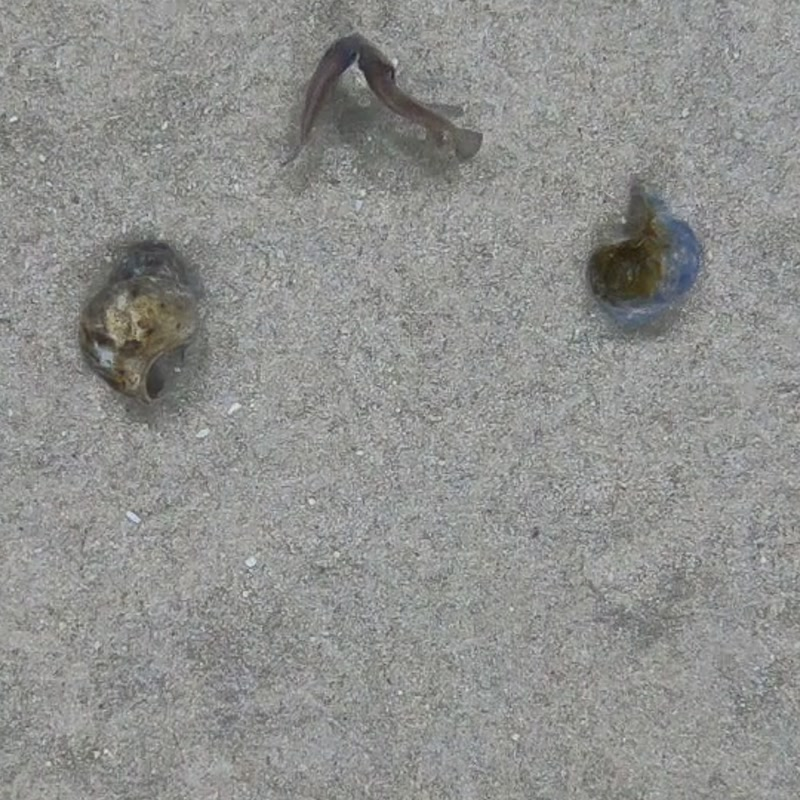

In [32]:
video_frames = glob.glob('data/raw/ocellatus_video_frames/*.jpg')
Image(filename=video_frames[np.random.randint(0, len(video_frames)-1)])

In [33]:
inception_features = np.load('data/ocellatus_inception_features.npy')
# encoder_features =  # TODO

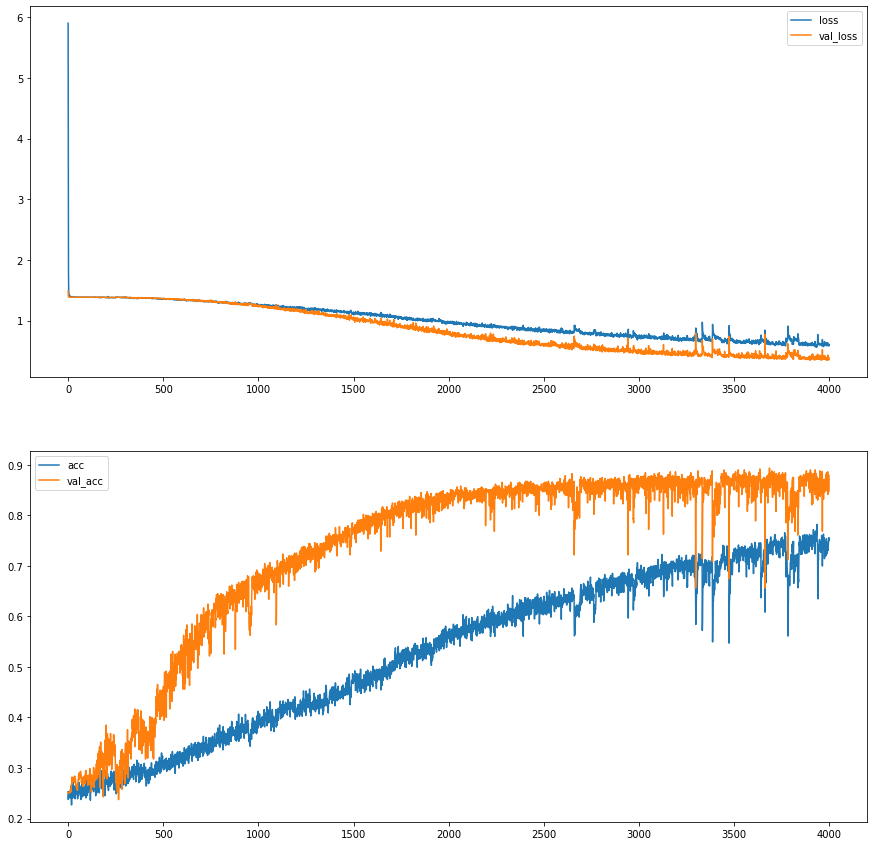

In [57]:
### data
features = inception_features
# features = preprocessing.scale(tracked_features)

seq_len = 64 
seq_stps = 8

X_train, Y_train = evenly_subsample_features(
    labels,
    features,
    idx,
    counts,
    seq_stps=seq_stps,
    seq_len=seq_len,
    n_features=features.shape[1],
)
X_train = X_train.reshape(
    (X_train.shape[0], X_train.shape[1], 1, X_train.shape[2], X_train.shape[3])
)

### model
conv_filters=8
conv_kernel_size=(1,5)
lstm_filters=10
dropout=0.9

conv_lstm_2d_model = build_conv_lstm_2d_model(
    input_shape=(
        X_train.shape[1],
        1,
        X_train.shape[3],
        X_train.shape[4]),
    conv_filters=conv_filters,
    conv_kernel_size=conv_kernel_size,
    lstm_filters=lstm_filters,
    dropout=dropout,
    nb_classes=Y_train.shape[1],
)

loss = 'categorical_crossentropy'
optimizer = Adam(lr=1e-5)
metrics = ['accuracy']

conv_lstm_2d_model.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=metrics)

conv_lstm_2d_model.summary()

### training
batch_size = 64
validation_split = 0.2
n_epochs = 4000

conv_lstm_2d_model.fit(
    X_train, Y_train,
    validation_split=validation_split,
    batch_size=batch_size,
    epochs=n_epochs,
    shuffle=True,
    callbacks=[plot_losses],
    verbose=0
            )

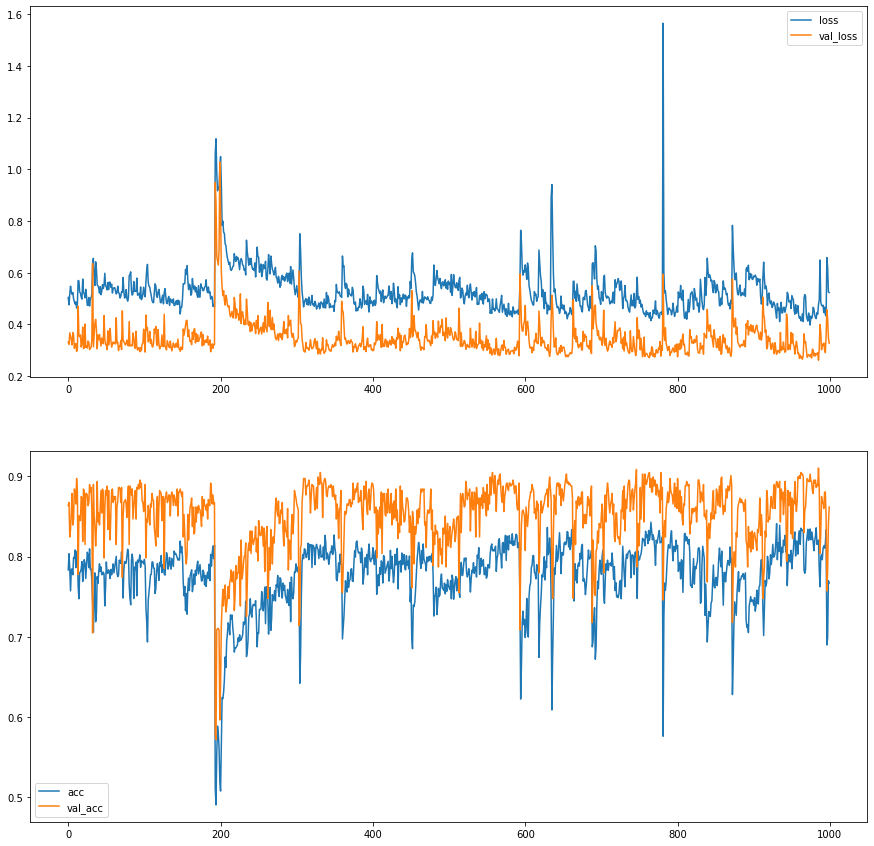

In [59]:
n_epochs = 1000

conv_lstm_2d_model.fit(
    X_train, Y_train,
    validation_split=validation_split,
    batch_size=batch_size,
    epochs=n_epochs,
    shuffle=True,
    callbacks=[plot_losses],
    verbose=0
            )

In [107]:
seq_len = 64 
seq_stps = 8
ix = np.random.randint(0,len(features))
X_test = features[
    ix-int(seq_len/2):
    ix+int(seq_len/2)].reshape((1, seq_stps, 1, int(seq_len/seq_stps), features.shape[1]))
Y_test = labels[ix].reshape(1, labels.shape[1])
print('{} == {} ?'.format(np.argmax(conv_lstm_2d_model.predict(X_test)), np.argmax(Y_test)))

3 == 3 ?


In [1]:
conv_lstm_2d_model.predict(X_test), Y_test

NameError: name 'conv_lstm_2d_model' is not defined

In [ ]:
from keras import backend as K
K.clear_session()

In [49]:
class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state """

            assert_msg = "States must be a list. However states {} is of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch_size*en_seq_len, latent_dim
            reshaped_enc_outputs = K.reshape(encoder_out_seq, (-1, en_hidden))
            # <= batch_size*en_seq_len, latent_dim
            W_a_dot_s = K.reshape(K.dot(reshaped_enc_outputs, self.W_a), (-1, en_seq_len, en_hidden))
            if verbose:
                print('wa.s>',W_a_dot_s.shape)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>',U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            reshaped_Ws_plus_Uh = K.tanh(K.reshape(W_a_dot_s + U_a_dot_h, (-1, en_hidden)))
            if verbose:
                print('Ws+Uh>', reshaped_Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.reshape(K.dot(reshaped_Ws_plus_Uh, self.V_a), (-1, en_seq_len))
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """
            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        def create_inital_state(inputs, hidden_size):
            # We are not using initial states, but need to pass something to K.rnn funciton
            fake_state = K.zeros_like(inputs)  # <= (batch_size, enc_seq_len, latent_dim
            fake_state = K.sum(fake_state, axis=[1, 2])  # <= (batch_size)
            fake_state = K.expand_dims(fake_state)  # <= (batch_size, 1)
            fake_state = K.tile(fake_state, [1, hidden_size])  # <= (batch_size, latent_dim
            return fake_state

        fake_state_c = create_inital_state(encoder_out_seq, encoder_out_seq.shape[-1])
        fake_state_e = create_inital_state(encoder_out_seq, encoder_out_seq.shape[1])  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]